<a href="https://colab.research.google.com/github/Tahimi/AdvectionDifusionEMA2L/blob/main/advectionDiffusionEq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Fipy and mount the drive for input/output

In [66]:
!pip install fipy
# obs. restart runtime environment after installing fipy, press Ctrl+M

In [67]:
# mounting the drive
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Diffusion Eq. in 1D: Finite Differences vs. Finite Volumes

---



In [14]:
# space discretization
import numpy as np
from fipy import *

xL = 0.
xR = 1000. * 1.4
dx = 10.

delX = xR - xL
nx = int(delX/dx)
x4FD = np.linspace(xL, xR, nx+1)
mesh4FV = Grid1D(nx=nx, dx=dx) + xL

In [15]:
# time discretization
# Fr: adimensional Fourier number

D = 20.
Fr = 0.5
tL = 0.
delT = 5*60. # seconds

dt = Fr*dx**2/D
stepsNbr = int(delT/dt)
tR = tL + stepsNbr*dt

In [16]:
# defining the initial distribution

def gaussianDistributionIn1D(x, yMin, yMax, xc, width):
    return yMin + (yMax-yMin)*np.exp(-(x-xc)**2/(2*width**2))

In [17]:
# unkown's initialization

yMin = 200.
yMax = 1200.
xc = 250.
width = 40.

delY = yMax - yMin

def initialize4FD():
    global x4FD, yMin, yMax, xc, width, yInit4FD, y4FD
    yInit4FD = gaussianDistributionIn1D(x=x4FD,
                                        yMin=yMin,
                                        yMax=yMax,
                                        xc=xc,
                                        width=width)
    y4FD = np.copy(yInit4FD)

def initialize4FV():
    global mesh4FV, yMin, yMax, xc, width, yInit4FV, y4FV
    yInit4FV = CellVariable(mesh=mesh4FV,
                            value=gaussianDistributionIn1D(x=mesh4FV.x,
                                                           yMin=yMin,
                                                           yMax=yMax,
                                                           xc=xc,
                                                           width=width))
    y4FV = CellVariable(mesh=mesh4FV,
                        value=yInit4FV)

    # defining the BCs and the discritized eq.
    # closed BC (Neumann), no leaving material, i.e. grad(y) = 0
    y4FV.faceGrad.constrain((0,), where=mesh4FV.exteriorFaces)

    # Defining the discretized equation
    global D, eq
    eq = TransientTerm() == ExplicitDiffusionTerm(coeff=D)

initialize4FD()
initialize4FV()

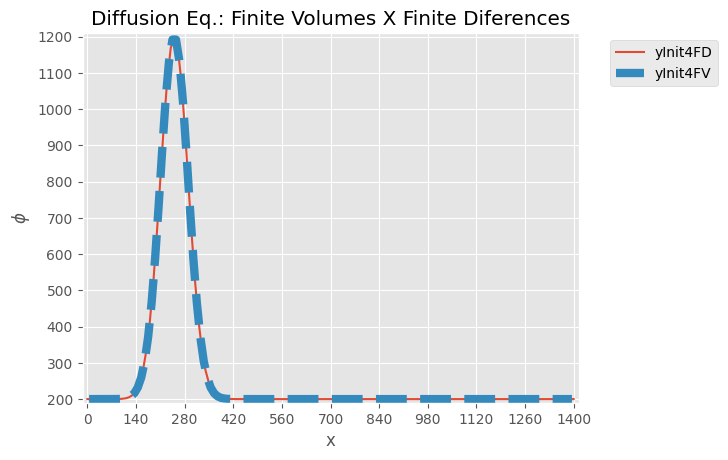

In [18]:
# ploting initial distribution
import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig, ax = plt.subplots()

ax.set_xlabel('x')
ax.set_ylabel(r'$\phi$')
plotTitle = ax.set_title("Diffusion Eq.: Finite Volumes X Finite Diferences")

dxplt = delX*0.1
dyplt = delY*0.1
plt.xticks(np.arange(xL, xR+dxplt/10, dxplt))
plt.yticks(np.arange(yMin, yMax+dyplt/10, dyplt))
ax.set_xlim(xL-dxplt/10, xR+dxplt/10)
ax.set_ylim(yMin-dyplt/10, yMax+dyplt/10)

plt.plot(x4FD, yInit4FD,
         label='yInit4FD')
plt.plot(mesh4FV.x, yInit4FV.value,
         label='yInit4FV', linestyle='dashed', linewidth=6)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [19]:
# defining the time-step update function: diffuse

# ExplicitFirstOrderDiffusionFiniteDiferenceScheme
# ForwardFirstOrderAccurateInTime
# centredSecondOrderAccurateInSpace
def diffuse4FD():
    global Fr, x4FD, y4FD
    yIN = np.copy(y4FD)
    y4FD *= 0

    # internal points
    for i in range(1,len(x4FD)-1):
        y4FD[i] = Fr*yIN[i-1] + (1.-2*Fr)*yIN[i] + Fr*yIN[i+1]

    # applying closed BC (Neumann)
    # i.e. no leaving material or grad(y) = 0
    y4FD[0] = Fr*yIN[1] + (1.-2*Fr)*yIN[0] + Fr*yIN[1]
    y4FD[-1] = Fr*yIN[-2] + (1.-2*Fr)*yIN[-1] + Fr*yIN[-2]

def diffuse4FV():
    global y4FV, dt
    eq.solve(var=y4FV, dt=dt)

In [20]:
# iterate in time

for step in range(stepsNbr):
    diffuse4FD()
    diffuse4FV()

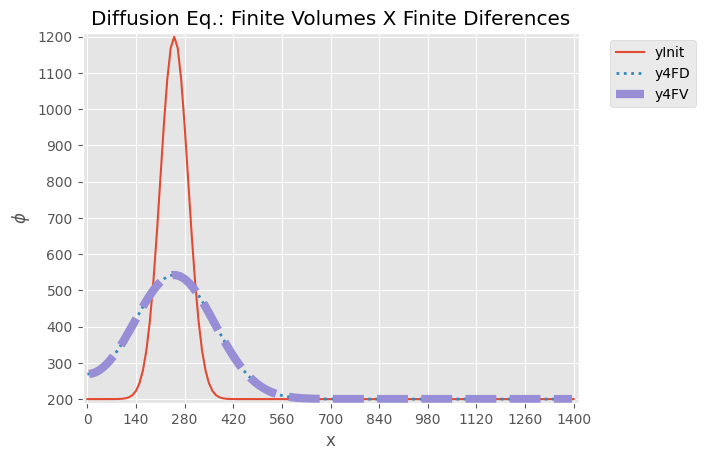

In [21]:
# ploting initial and final distribution
import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig, ax = plt.subplots()

ax.set_xlabel('x')
ax.set_ylabel(r'$\phi$')
plotTitle = ax.set_title("Diffusion Eq.: Finite Volumes X Finite Diferences")

dxplt = delX*0.1
dyplt = delY*0.1
plt.xticks(np.arange(xL, xR+dxplt/10, dxplt))
plt.yticks(np.arange(yMin, yMax+dyplt/10, dyplt))
ax.set_xlim(xL-dxplt/10, xR+dxplt/10)
ax.set_ylim(yMin-dyplt/10, yMax+dyplt/10)

plt.plot(x4FD, yInit4FD,
         label='yInit', linestyle='solid')

plt.plot(x4FD, y4FD,
         label='y4FD', linestyle='dotted', linewidth=2)
plt.plot(mesh4FV.x, y4FV.value,
         label='y4FV', linestyle='dashed', linewidth=6)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [22]:
# saving the plot into file

outputFileName = '/content/drive/MyDrive/DiffusionEq/fvXfd_diffusion1D.jpg'
fig.savefig(outputFileName)

In [23]:
# producing the animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

plt.style.use("ggplot")
fig, ax = plt.subplots()

plotLine, = ax.plot(mesh4FV.x, np.zeros(len(mesh4FV.x))*np.NaN, 'r-')
plotTitle = ax.set_title("t = " + str(tL))

dxplt = delX*0.1
dyplt = delY*0.1
plt.xticks(np.arange(xL, xR+dxplt/10, dxplt))
plt.yticks(np.arange(yMin, yMax+dyplt/10, dyplt))

ax.set_xlim(xL-dxplt/10, xR+dxplt/10)
ax.set_ylim(yMin-dyplt/10, yMax+dyplt/10)

def animate(t):
    if t < tL + dt/10.:
        initialize4FV()
    ycopy = np.copy(y4FV)
    plotLine.set_ydata(ycopy)
    plotTitle.set_text('t = ' + str(round(t,3)))
    diffuse4FV()
    return [plotLine, plotTitle]

ani = animation.FuncAnimation(fig, func=animate, frames=np.arange(tL, tR, dt), repeat=True, blit=False)
plt.close(fig)
HTML(ani.to_html5_video())

In [24]:
# saving the animation into file

outputFileName = '/content/drive/MyDrive/DiffusionEq/fvXfd_diffusion1D.gif'
ani.save(outputFileName, writer='ffmpeg')

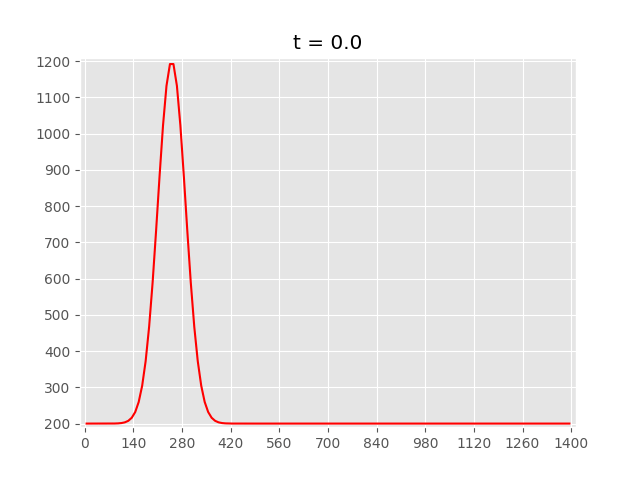

In [25]:
# reading the animation file, (if needed).
from IPython.display import Image

Image(open(outputFileName,'rb').read())

In [27]:
y4FV.value.max()

542.1651839241731

## Diffusion Eq. in 2D: Finite Volumes

---

In [40]:
# space discretization
import numpy as np
from fipy import *

w = h = 1000 # meters
dx = dy = 10
nx, ny = int(w/dx), int(h/dy)
mesh = Grid2D(nx=nx, dx=dx, ny=ny, dy=dy)

In [41]:
# time discretization

Fr = 0.5
D = 20.
tL = 0.
delT = 5*60. # seconds

dt = abs(Fr*(dx**2+dy**2)/D)
stepsNbr = int(delT/dt)
tR = tL + stepsNbr*dt

In [42]:
# defining the unkown's distribution

def gaussianDistributionIn2D(x, y, zMin, zMax, xc, yc, width):
    return zMin + (zMax-zMin) * np.exp(-((x-xc)**2+(y-yc)**2) / (2*width**2))

In [43]:
# unkown's initialization

zMin, zMax = 200., 1200.
xc, yc = 250., 250.
width = 40.

delZ = zMax - zMin

def initialize():
    global mesh, zMin, zMax, xc, yc, width, zInit, z
    zInit = CellVariable(mesh=mesh,
                         value=gaussianDistributionIn2D(x=mesh.x,
                                                        y=mesh.y,
                                                        zMin=zMin,
                                                        zMax=zMax,
                                                        xc=xc,
                                                        yc=yc,
                                                        width=width))
    z = CellVariable(mesh=mesh, value=zInit)

    # Applying noFlow BC
    z.faceGrad.constrain((0,), where=mesh.exteriorFaces)

    # Defining the discritized equation
    global D, eq
    eq = (TransientTerm() == DiffusionTerm(coeff=D))

initialize()

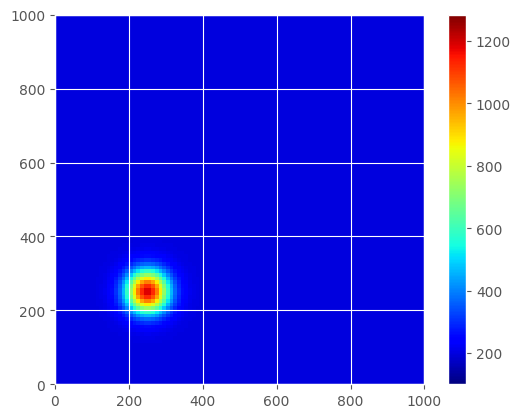

In [44]:
# ploting the unkown's initial distribution

viewer = Viewer(vars = (zInit),
                datamin = zInit.min()-delZ*.1,
                datamax = zInit.max()+delZ*.1)
viewer.plot()

In [45]:
# saving the plot into file

fv2DzInit_FileName = '/content/drive/MyDrive/DiffusionEq/fv2DzInit.jpg'
viewer.plot(fv2DzInit_FileName)

In [46]:
# defining the time-step update function: diffuse

def diffuse():
    global z, dt
    eq.solve(var=z, dt=dt)

In [47]:
# iterate in time

for step in range(stepsNbr):
    diffuse()

After 300.0  (sec)


<Figure size 640x480 with 0 Axes>

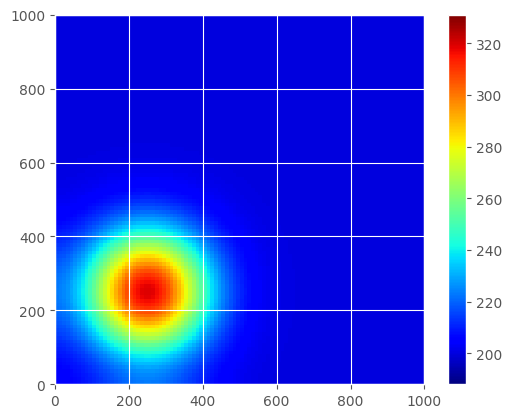

In [48]:
# ploting the unkown's final distribution

print('After', dt*stepsNbr, ' (sec)')
delZ = z.max() - z.min()
viewer = Viewer(vars = (z),
                datamin = z.min()-delZ*.1,
                datamax = z.max()+delZ*.1)
viewer.plot()

In [49]:
# saving the plot into file

fv2DzFinal_FileName = '/content/drive/MyDrive/DiffusionEq/fv2DzFinal.jpg'
viewer.plot(fv2DzFinal_FileName)

In [50]:
z.value.max()

319.200101324099

## Advection Eq. in 1D: Finite Differences vs. Finite Volumes

---

In [28]:
# space discretization
import numpy as np
from fipy import *

xL = 0.
xR = 1000. * 1.4 # meters
dx = 10.

delX = xR - xL
nx = int(delX/dx)
x4FD = np.linspace(xL, xR, nx+1)
mesh4FV = Grid1D(nx=nx, dx=dx) + xL

In [29]:
# time discretization
# Cr: adimensional Courant number

Cr = 0.8
u = 2.
tL = 0.
delT = 5*60. # seconds

dt = Cr*dx/u
stepsNbr = int(delT/dt)
tR = tL + stepsNbr*dt

In [30]:
# defining the initial distribution

def gaussianDistributionIn1D(x, yMin, yMax, xc, width):
    return yMin + (yMax-yMin)*np.exp(-(x-xc)**2/(2*width**2))

In [31]:
# unkown's initialization

yMin, yMax = 200., 1200.
xc = 250.
width = 40.

delY = yMax - yMin

def initialize4FD():
    global x4FD, yMin, yMax, xc, width, yInit4FD, y4FD
    yInit4FD = gaussianDistributionIn1D(x=x4FD,
                                        yMin=yMin,
                                        yMax=yMax,
                                        xc=xc,
                                        width=width)
    y4FD = np.copy(yInit4FD)

def initialize4FV():
    global mesh4FV, yMin, yMax, xc, width, yInit4FV, y4FV
    yInit4FV = CellVariable(mesh=mesh4FV,
                            value=gaussianDistributionIn1D(x=mesh4FV.x,
                                                           yMin=yMin,
                                                           yMax=yMax,
                                                           xc=xc,
                                                           width=width))
    y4FV = CellVariable(mesh=mesh4FV,
                        value=yInit4FV)

    # defining the BCs and the discritized eq.
    # Dirichlet BC upstream (added as a constraint)
    # Absorbing BC downstream (added in the equation, since depend on the solution)
    y4FV.faceValue.constrain(yMin, where=mesh4FV.facesLeft)

    # Defining the discretized equation
    global u, eq
    convCoeff = (u,)
    eq = (TransientTerm(var=y4FV) + ExplicitUpwindConvectionTerm(coeff=convCoeff, var=y4FV) \
       == - ((convCoeff * y4FV.faceValue) * mesh4FV.facesRight).divergence)

initialize4FD()
initialize4FV()

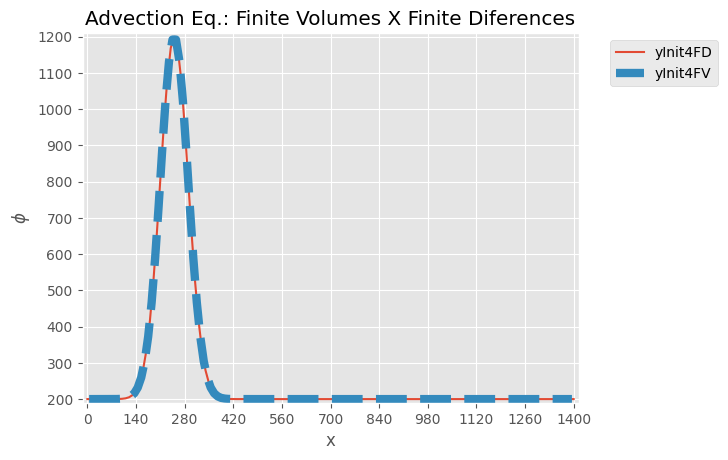

In [32]:
# ploting initial distribution
import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig, ax = plt.subplots()

ax.set_xlabel('x')
ax.set_ylabel(r'$\phi$')
plotTitle = ax.set_title("Advection Eq.: Finite Volumes X Finite Diferences")

dxplt = delX*0.1
dyplt = delY*0.1
plt.xticks(np.arange(xL, xR+dxplt/10, dxplt))
plt.yticks(np.arange(yMin, yMax+dyplt/10, dyplt))
ax.set_xlim(xL-dxplt/10, xR+dxplt/10)
ax.set_ylim(yMin-dyplt/10, yMax+dyplt/10)

plt.plot(x4FD, yInit4FD,
         label='yInit4FD')
plt.plot(mesh4FV.x, yInit4FV.value,
         label='yInit4FV', linestyle='dashed', linewidth=6)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [33]:
# defining the time-step update function: advect

# oneStepExplicitFirstOrderUpwindAdvectionScheme
# ForwardFirstOrderAccurateInTime
# upwindFirstOrderAccurateInSpace
# obs. only u > 0 is implemented, i.e. upwind is backward
def advect4FD():
    global Cr, x4FD, y4FD
    yIN = np.copy(y4FD)
    y4FD *= 0

    # internal points
    for i in range(1,len(x4FD)-1):
        y4FD[i] = Cr*yIN[i-1] + (1.-Cr)*yIN[i]

    # Dirichlet BC upstream
    y4FD[0] = yMin
    # Absorbing BC downstream
    y4FD[-1] = Cr*yIN[-2] + (1.-Cr)*yIN[-1]

def advect4FV():
    global y4FV, dt
    eq.solve(var=y4FV, dt=dt)

In [34]:
# iterate in time

for step in range(stepsNbr):
    advect4FD()
    advect4FV()

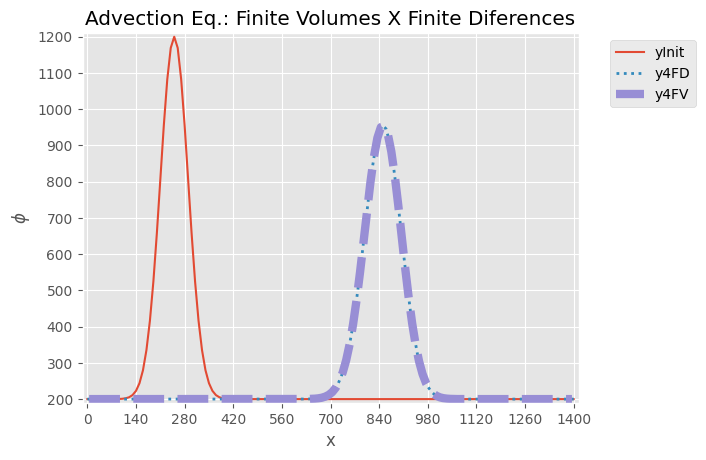

In [35]:
# ploting initial distribution
import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig, ax = plt.subplots()

ax.set_xlabel('x')
ax.set_ylabel(r'$\phi$')
plotTitle = ax.set_title("Advection Eq.: Finite Volumes X Finite Diferences")

dxplt = delX*0.1
dyplt = delY*0.1
plt.xticks(np.arange(xL, xR+dxplt/10, dxplt))
plt.yticks(np.arange(yMin, yMax+dyplt/10, dyplt))
ax.set_xlim(xL-dxplt/10, xR+dxplt/10)
ax.set_ylim(yMin-dyplt/10, yMax+dyplt/10)

plt.plot(x4FD, yInit4FD,
         label='yInit', linestyle='solid')

plt.plot(x4FD, y4FD,
         label='y4FD', linestyle='dotted', linewidth=2)
plt.plot(mesh4FV.x, y4FV.value,
         label='y4FV', linestyle='dashed', linewidth=6)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [36]:
# saving the plot into file

outputFileName = '/content/drive/MyDrive/DiffusionEq/fvXfd_advection1D.jpg'
fig.savefig(outputFileName, dpi = 150)

In [37]:
# producing the animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()
plotLine, = ax.plot(mesh4FV.x, np.zeros(len(mesh4FV.x))*np.NaN, 'r-')
plotTitle = ax.set_title("t = " + str(tL))

dxplt = delX*0.1
dyplt = delY*0.1
plt.xticks(np.arange(xL, xR+dxplt/10, dxplt))
plt.yticks(np.arange(yMin, yMax+dyplt/10, dyplt))

ax.set_xlim(xL-dxplt/10, xR+dxplt/10)
ax.set_ylim(yMin-dyplt/10, yMax+dyplt/10)

def animate(t):
    if t < tL + dt/10.:
        initialize4FV()
    ycopy = np.copy(y4FV)
    plotLine.set_ydata(ycopy)
    plotTitle.set_text('t = ' + str(round(t,3)))
    advect4FV()
    return [plotLine, plotTitle]

ani = animation.FuncAnimation(fig, func=animate, frames=np.arange(tL, tR, dt), repeat=True, blit=False)
plt.close(fig)
HTML(ani.to_html5_video())

In [38]:
# saving the animation into file

outputFileName = '/content/drive/MyDrive/DiffusionEq/fvXfd_advection1D.gif'
ani.save(outputFileName, writer='ffmpeg')

In [39]:
y4FV.value.max()

953.9891319950159

## Advection Eq. in 2D: Finite Volumes

---

In [51]:
# space discretization
import numpy as np
from fipy import *

w = h = 1000. # meters
dx = dy = 10.
nx, ny = int(w/dx), int(h/dy)
mesh = Grid2D(nx=nx, dx=dx, ny=ny, dy=dy)

In [52]:
# time discretization

Cr = 0.8 # Courant Number: Cr = u*dt/dx
vx = vy = 2. # m/s
tL = 0.
delT = 5*60. # sec

dt = abs(Cr*np.sqrt(dx**2+dy**2)/np.sqrt(vx**2+vy**2))
stepsNbr = int(delT/dt)
tR = tL + stepsNbr*dt

In [53]:
# defining the unkown's distribution

def gaussianDistributionIn2D(x, y, zMin, zMax, xc, yc, width):
    return zMin + (zMax-zMin) * np.exp(-((x-xc)**2+(y-yc)**2) / (2*width**2))

In [54]:
# unkown's initialization

zMin, zMax = 200., 1200.
xc, yc = 250., 250.
width = 40.

delZ = zMax - zMin

def initialize():
    global mesh, zMin, zMax, xc, yc, width, zInit, z
    zInit = CellVariable(mesh=mesh,
                         value=gaussianDistributionIn2D(x=mesh.x,
                                                        y=mesh.y,
                                                        zMin=zMin,
                                                        zMax=zMax,
                                                        xc=xc,
                                                        yc=yc,
                                                        width=width))
    z = CellVariable(mesh=mesh, value=zInit)

    # Applying noFlow BC
    z.faceGrad.constrain((0,), where=mesh.exteriorFaces)

    # Defining the discret equation
    global vx, vy, eq
    convCoeff = (vx,vy)
    eq = (TransientTerm() + PowerLawConvectionTerm(coeff=convCoeff)  == 0)

initialize()

<Figure size 640x480 with 0 Axes>

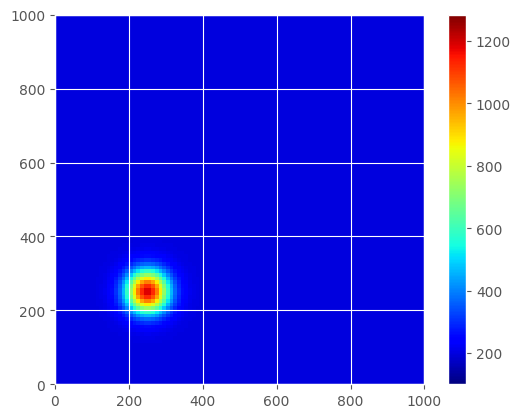

In [55]:
# ploting the unkown's initial distribution

viewer = Viewer(vars = (zInit),
                datamin = zInit.min()-delZ*.1,
                datamax = zInit.max()+delZ*.1)
viewer.plot()

In [56]:
# saving the plot into file

outputFileName = '/content/drive/MyDrive/DiffusionEq/fv2DzInitAdv.jpg'
viewer.plot(outputFileName)

In [57]:
# defining the time-step update function: diffuse

def advect():
    global z, dt
    eq.solve(var=z, dt=dt)

In [58]:
# iterate in time

for step in range(stepsNbr):
    advect()

After 300.0  (sec)


<Figure size 640x480 with 0 Axes>

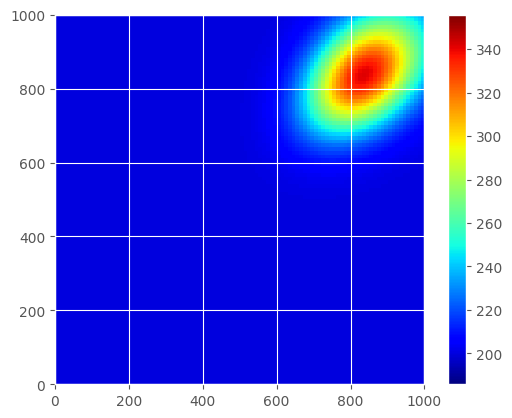

In [59]:
# ploting the unkown's final distribution

print('After', dt*stepsNbr, ' (sec)')
delZ = z.max() - z.min()
viewer = Viewer(vars = (z),
                datamin = z.min()-delZ*.1,
                datamax = z.max()+delZ*.1)
viewer.plot()

In [60]:
# saving the plot into file

outputFileName = '/content/drive/MyDrive/DiffusionEq/fv2DzFinalAdv.jpg'
viewer.plot(outputFileName)

In [61]:
z.value.max()

341.64144245769756

## Advection-Diffusion Eq. in 2D: Finite Volumes

---



In [62]:
# space discretization
import numpy as np
from fipy import *

w = h = 1000. # meters
dx = dy = 10. # m
nx, ny = int(w/dx), int(h/dy)
mesh = Grid2D(nx=nx, dx=dx, ny=ny, dy=dy)

In [63]:
# time discretization

# advection
Cr = 0.8 # Courant Number: Cr = u*dt/dx
vx = vy = 2. # m/s
dtAdv = abs(Cr*np.sqrt(dx**2+dy**2)/np.sqrt(vx**2+vy**2))

# diffusion
Fr = 0.5 # Fourier Number: Fr = D*dt/dx**2
D = 20.
dtDiff = abs(Fr*(dx**2+dy**2)/D)

# advection & diffusion
dt = min(dtAdv, dtDiff)
delT = 5*60. # sec
stepsNbr = int(delT/dt)

In [64]:
# defining the unkown's distribution

def gaussianDistributionIn2D(x, y, zMin, zMax, xc, yc, width):
    return zMin + (zMax-zMin) * np.exp(-((x-xc)**2+(y-yc)**2) / (2*width**2))

In [65]:
# unkown's initialization

zMin, zMax = 200., 1200.
xc, yc = 250., 250.
width = 40.

delZ = zMax - zMin

def initialize():
    global mesh, zMin, zMax, xc, yc, width, zInit, z
    zInit = CellVariable(mesh=mesh,
                         value=gaussianDistributionIn2D(x=mesh.x,
                                                        y=mesh.y,
                                                        zMin=zMin,
                                                        zMax=zMax,
                                                        xc=xc,
                                                        yc=yc,
                                                        width=width))
    z = CellVariable(mesh=mesh, value=zInit)

    # Applying noFlow BC
    z.faceGrad.constrain((0,), where=mesh.exteriorFaces)

    # Defining the discritized equation
    global vx, vy, D, eq
    eq = (TransientTerm() + PowerLawConvectionTerm(coeff=(vx,vy)) == DiffusionTerm(coeff=D))

initialize()

<Figure size 640x480 with 0 Axes>

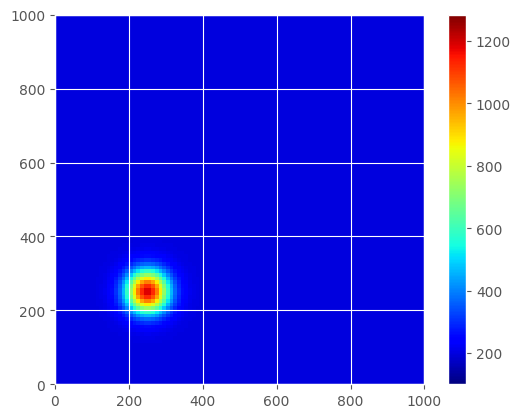

In [66]:
# ploting the unkown's initial distribution

viewer = Viewer(vars = (zInit),
                datamin = zInit.min()-delZ*.1,
                datamax = zInit.max()+delZ*.1)
viewer.plot()

In [67]:
# saving the plot into file

outputFileName = '/content/drive/MyDrive/DiffusionEq/fv2DzInitAdvDiff.jpg'
viewer.plot(outputFileName)

In [68]:
# defining the time-step update function: diffuse

def advectAndDiffuse():
    global z, dt
    eq.solve(var=z, dt=dt)

In [69]:
# iterate in time

for step in range(stepsNbr):
    advectAndDiffuse()

After 300.0  (sec)


<Figure size 640x480 with 0 Axes>

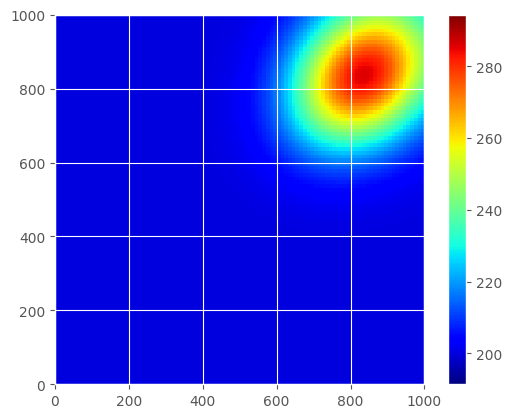

In [70]:
# ploting the unkown's final distribution

print('After', dt*stepsNbr, ' (sec)')
delZ = z.max() - z.min()
viewer = Viewer(vars = (z),
                datamin = z.min()-delZ*.1,
                datamax = z.max()+delZ*.1)
viewer.plot()

In [71]:
# saving the plot into file

outputFileName = '/content/drive/MyDrive/DiffusionEq/fv2DzFinalAdvDiff.jpg'
viewer.plot(outputFileName)

In [72]:
z.value.max()

285.80501291604054